In [1]:
from os import listdir, path
import numpy as np
import scipy
import cv2
import os, sys
from generator import create_model_residual, create_model
from keras.callbacks import ModelCheckpoint, Callback
from glob import glob
import pickle, argparse
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="1"

half_window_size = 4
mel_step_size = 27

Using TensorFlow backend.


### Arguments

In [2]:
from easydict import EasyDict
args = EasyDict(data_root='LipGAN_dataset_local',
               batch_size=200,
               lr=1e-3,
               img_size=96,
               logdir='logs_ipynb',
               all_images='filenames.pkl')
print(args)

{'data_root': 'LipGAN_dataset_local', 'batch_size': 200, 'lr': 0.001, 'img_size': 96, 'logdir': 'logs_ipynb', 'all_images': 'filenames.pkl'}


### Dataset

In [3]:
import numpy as np
import torch
import librosa
from torch.utils.data import DataLoader

half_window_size = 4
mel_step_size = 27
    
def frame_id(fname):
    return int(os.path.basename(fname).split('.')[0])

def choose_ip_frame(frames, gt_frame):
    selected_frames = [f for f in frames if np.abs(frame_id(gt_frame) - frame_id(f)) >= 6]
    if len(selected_frames) == 0:
        selected_frames = frames
        
    return np.random.choice(selected_frames)

def get_audio_segment(center_frame, spec):
    center_frame_id = frame_id(center_frame)
    start_frame_id = center_frame_id - half_window_size

    start_idx = int((81./25.) * start_frame_id) # 25 is fps of LRS2
    end_idx = start_idx + mel_step_size

    return spec[:, start_idx : end_idx] if end_idx <= spec.shape[1] else None

def bgr2rgb(x):
    temp = x[:, :, 0].copy()
    x[:, :, 0] = x[:, :, 2]
    x[:, :, 2] = temp
    
    return x

class LipDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        
        if not path.exists(args.logdir):
            os.mkdir(args.logdir)

        if path.exists(path.join(args.logdir, args.all_images)):
            all_images = pickle.load(open(path.join(args.logdir, args.all_images), 'rb'))
        else:
            all_images = glob(path.join("{}/train/*/*/*.jpg".format(args.data_root)))
            pickle.dump(all_images, open(path.join(args.logdir, args.all_images), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

        print ("Will be training on {} images".format(len(all_images)))
        
        np.random.shuffle(all_images)
        self.batches = all_images
 
    def __getitem__(self, index):
        while(True):
            
            index = np.random.randint(0, len(self.batches))

            '''Get a frame'''
            img_name = self.batches[index]
            gt_fname = os.path.basename(img_name)
            dir_name = img_name.replace(gt_fname, '')
            frames = glob(dir_name + '/*.jpg')
            
            if len(frames) < 12:
                continue

            '''Get a melspectrogram'''
            mel_fname = dir_name + "./mels.npz"
            mel = np.load(mel_fname)['spec']
            mel = get_audio_segment(gt_fname, mel)
            
            if mel is None or mel.shape[1] != mel_step_size:
                continue
                
            if sum(np.isnan(mel.flatten())) > 0:
                continue    

            '''Ground Truth & IP '''
            img_gt = cv2.imread(img_name)        
            img_gt = bgr2rgb(img_gt)
            img_gt = img_gt / 255.0
            img_gt = cv2.resize(img_gt, (args.img_size, args.img_size))

            img_gt_masked = img_gt.copy()
            img_gt_masked[args.img_size//2:] = 0 

            ip_fname = choose_ip_frame(frames, gt_fname)
            img_ip = cv2.imread(ip_fname)
            img_ip = bgr2rgb(img_ip)
            img_ip = img_ip / 255.0
            img_ip = cv2.resize(img_ip, (args.img_size, args.img_size))

            img_gt = img_gt.transpose(2, 0, 1)
            img_gt_masked = img_gt_masked.transpose(2, 0, 1)
            img_ip = img_ip.transpose(2, 0, 1)
            
            break
        
        return (img_gt, img_gt_masked, img_ip, mel)

    def __len__(self):
        return len(self.batches)

trainset = LipDataset(args)
# =====END:   ADDED FOR DISTRIBUTED======
train_loader = DataLoader(trainset, num_workers=16, shuffle=True,
                          sampler=None,
                          batch_size=args.batch_size,
                          pin_memory=False,
                          drop_last=True)


Will be training on 1678240 images


### Model

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm_notebook as tqdm

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding='same', act=True):
        super().__init__()
        if padding is 'same':
            num_pad = int((kernel_size - 1) / 2)
        else:
            num_pad = 0
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=num_pad)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels, momentum=0.8)
        self.act = act
        
    def forward(self, x):
        x = self.conv(x)
        if x.size(2) > 1 or x.size(3) > 1:
            x = self.batch_norm(x)
        if self.act:
            F.relu(x)
            
        return x
    
class TransposedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0, act=True):
        super().__init__()
        self.transposed_conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                                                  kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels, momentum=0.8)
        self.act = act
        
    def forward(self, x):
        x = self.transposed_conv(x)
        if x.size(2) > 1 or x.size(3) > 1:
            x = self.batch_norm(x)
        if self.act:
            F.relu(x)
            
        return x

class FaceEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.identity_mapping = ConvBlock(in_channels=6, out_channels=32, kernel_size=11, stride=1) # 32x96x96
        self.conv_list = nn.ModuleList([ConvBlock(in_channels=32, out_channels=64, kernel_size=7, stride=2),   #  64x48x48
                                      ConvBlock(in_channels=64, out_channels=128, kernel_size=5, stride=2),  # 128x24x24
                                      ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2), # 256x12x12
                                      ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2), # 512x6x6
                                      ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2), # 512x3x3
                                      ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='valid'), #512x1x1 
                                      ConvBlock(in_channels=512, out_channels=256, kernel_size=1, stride=1)]) # 256x1x1

    def forward(self, x):
        # x : (B, 6, 96, 96)

        # (B, 32, 96, 96)
        x = self.identity_mapping(x)
        
        x_list = [x]
        for conv in self.conv_list:
            x = conv(x)
            x_list.append(x)
        
        return x_list
    
class AudioEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(ConvBlock(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same'),
                                ConvBlock(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same'),
                                ConvBlock(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same'), # 32x80x27

                                ConvBlock(in_channels=32, out_channels=64, kernel_size=3, stride=3, padding='same'),
                                ConvBlock(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
                                ConvBlock(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'), # 64x27x9

                                ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=(3, 1), padding='same'),
                                ConvBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
                                ConvBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'), # 128x9x9

                                ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=3, padding='same'),
                                ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same'),
                                ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same'), # 256x3x3

                                ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='valid'),
                                ConvBlock(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding='same')) # 512x1x1
        
    def forward(self, x):
        # x : (B, 1, 80, 27)
        
        # (B, 512, 1, 1)
        x = self.convs(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prenet = nn.Sequential(ConvBlock(in_channels=768, out_channels=512, kernel_size=1, stride=1),
                                    TransposedConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=3))
        
        self.transposed_convs = nn.ModuleList([TransposedConvBlock(in_channels=1024, out_channels=512, kernel_size=3, stride=2),
                                               TransposedConvBlock(in_channels=1024, out_channels=256, kernel_size=3, stride=2),
                                               TransposedConvBlock(in_channels=512, out_channels=128, kernel_size=3, stride=2),
                                               TransposedConvBlock(in_channels=256, out_channels=64, kernel_size=3, stride=2),
                                               TransposedConvBlock(in_channels=128, out_channels=32, kernel_size=3, stride=2)])
                                               
        self.postnet = nn.Sequential(ConvBlock(in_channels=64, out_channels=16, kernel_size=3, stride=1),
                                     ConvBlock(in_channels=16, out_channels=16, kernel_size=3, stride=1),
                                     nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1, stride=1))
        
    def forward(self, embedding, face_encoded):
        # embedding: (B, C=768, H=96, W=96)
        # face_encoded: 0(B, 32, 96, 96)
        #               1(B, 64, 48, 48)
        #               2(B, 128, 24, 24)
        #               3(B, 256, 12, 12)
        #               4(B, 512, 6, 6)
        #               5(B, 512, 3, 3)
        #               6(B, 512, 1, 1)
        #               7(B, 256, 1, 1)
                                 
        # (B, 512, 3, 3)
        x = self.prenet(embedding)
        # (B, 1024, 3, 3)
        x = torch.cat([face_encoded[5], x], dim=1)
        
        # (B, 512, 6, 6)
        x = self.transposed_convs[0](x)[:, :, :6, :6]
        # (B, 1024, 6, 6)
        x = torch.cat([face_encoded[4], x], dim=1)
                                               
        # (B, 256, 12, 12)
        x = self.transposed_convs[1](x)[:, :, :12, :12]
        # (B, 512, 12, 12)
        x = torch.cat([face_encoded[3], x], dim=1)
                                               
        # (B, 128, 24, 24)
        x = self.transposed_convs[2](x)[:, :, :24, :24]
        # (B, 256, 24, 24)
        x = torch.cat([face_encoded[2], x], dim=1)
                                               
        # (B, 64, 48, 48)
        x = self.transposed_convs[3](x)[:, :, :48, :48]
        # (B, 128, 48, 48)
        x = torch.cat([face_encoded[1], x], dim=1)
                                               
        # (B, 32, 96, 96)
        x = self.transposed_convs[4](x)[:, :, :96, :96]
        # (B, 64, 96, 96)
        x = torch.cat([face_encoded[0], x], dim=1)
        
        # (B, 3, 96, 96)
        x = self.postnet(x)
        x = torch.sigmoid(x)
        
        return x
                     
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.face_encoder = FaceEncoder()
        self.audio_encoder = AudioEncoder()
        self.decoder = Decoder()

    def forward(self, img_gt_masked, img_ip, mels):
        # img_gt_masked: (B, C=3, H=96, W=96)
        # img_ip: (B, C=3, H=96, W=96)
        # mels: (B, H=80, W=27)
        
        # (B, C=6, H=96, W=96)
        input_face = torch.cat([img_gt_masked, img_ip], dim=1)
        
        # (B, 32, 96, 96)
        # (B, 64, 48, 48)
        # (B, 128, 24, 24)
        # (B, 256, 12, 12)
        # (B, 512, 6, 6)
        # (B, 512, 3, 3)
        # (B, 512, 1, 1)
        # (B, 256, 1, 1)
        face_encoded = self.face_encoder(input_face)
        
        # (B, 512, 1, 1)
        audio_encoded = self.audio_encoder(mels.unsqueeze(1))
        
        # (B, 768, 1, 1)
        embedding = torch.cat([face_encoded[-1], audio_encoded], dim=1)
        
        # (B, 3, 96, 96)
        y = self.decoder(embedding, face_encoded)
        
        return y
        

In [8]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/train_pytorch'
logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1586077119.scpark-X299-WU8	save_153000  save_31000
events.out.tfevents.1586077129.scpark-X299-WU8	save_154000  save_32000
events.out.tfevents.1586077338.scpark-X299-WU8	save_155000  save_33000
events.out.tfevents.1586077408.scpark-X299-WU8	save_156000  save_34000
events.out.tfevents.1586077704.scpark-X299-WU8	save_157000  save_35000
events.out.tfevents.1586077763.scpark-X299-WU8	save_158000  save_36000
events.out.tfevents.1586077848.scpark-X299-WU8	save_159000  save_37000
events.out.tfevents.1586077899.scpark-X299-WU8	save_16000   save_38000
events.out.tfevents.1586077943.scpark-X299-WU8	save_160000  save_39000
events.out.tfevents.1586078011.scpark-X299-WU8	save_161000  save_4000
events.out.tfevents.1586083057.scpark-X299-WU8	save_162000  save_40000
events.out.tfevents.1586083132.scpark-X299-WU8	save_163000  save_41000
events.out.tfevents.1586083187.scpark-X299-WU8	save_164000  save_42000
events.out.tfevents.1586086946.scpark-X299-WU8	save_165000  save_43000
events.

loaded
done


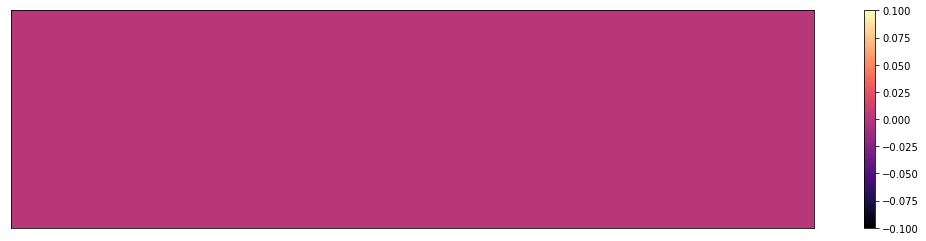

In [10]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time
import torch.distributed as dist

def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 214446
GPU = 0

model = Model()
model.cuda(GPU)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

path = get_save_path(save_dir, step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')

print('done')

plt.figure(figsize=[18, 4])
librosa.display.specshow(np.zeros([100, 100]))
plt.colorbar()
plt.show()




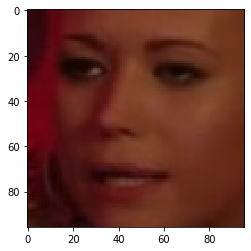

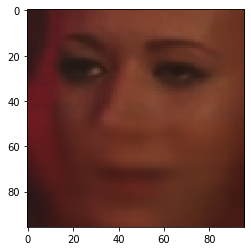

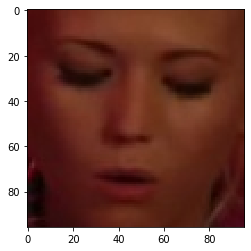

25.65139670130613 215246 0.036735109984874725 0.6075229644775391
25.65151587377252 215247 0.036485008895397186 0.35536670684814453
25.651635046238916 215248 0.03623659908771515 0.35409998893737793
25.651754218705307 215249 0.03599970415234566 0.3521435260772705


In [ ]:
t0 = time.time()

while(True):
    for i, batch in enumerate(train_loader):
        
        img_gt, img_gt_masked, img_ip, mels = batch
        img_gt = img_gt.cuda(GPU).float()
        img_gt_masked = img_gt_masked.cuda(GPU).float()
        img_ip = img_ip.cuda(GPU).float()
        mels = mels.cuda(GPU).float()
        
        model.zero_grad()
        img_out = model(img_gt_masked, img_ip, mels)
        loss = torch.mean(torch.abs(img_out - img_gt))
        loss.backward()
        
        #grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        t1 = time.time()
        one_epoch = len(trainset.batches) / args.batch_size
        print(step/one_epoch, step, loss.item(), t1 - t0)
        t0 = time.time()

        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)


        if i % 100 == 0:
            clear_output() 
            
            _img_gt = img_gt.data.cpu().numpy()
            _img_out = img_out.data.cpu().numpy()
            _img_ip = img_ip.data.cpu().numpy()
            
            plt.imshow(_img_gt[0].transpose(1, 2, 0))
            plt.show()
            plt.imshow(_img_out[0].transpose(1, 2, 0))
            plt.show()
            plt.imshow(_img_ip[0].transpose(1, 2, 0))
            plt.show()
        
        step += 1

In [ ]:
path = get_save_path(save_dir, step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)

In [ ]:

print(one_epoch)